### Using Glove Vectors from Spacy with Decision Tree Model 

In [15]:
import spacy
import pandas as pd
import matplotlib.pyplot as mplt
import seaborn as sn
import matplotlib.pyplot as plt                     
import numpy as np           
import plotly.offline as plyo

In [16]:
import random
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
import unicodedata
from collections import defaultdict
import string

from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from tqdm import tqdm

In [33]:
nlp = spacy.load("en_core_web_sm")

In [17]:
sample_submission_data = pd.read_csv("Data/OriginalData/sample_submission.csv")
test_data = pd.read_csv("Data/OriginalData/test.csv")
train_data = pd.read_csv("Data/OriginalData/train.csv")

In [24]:
import numpy as np
import spacy
from sklearn.base import BaseEstimator, TransformerMixin

class GloveVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name="en_core_web_sm"):
        self._nlp = spacy.load(model_name)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.concatenate(
            [self._nlp(doc).vector.reshape(1, -1) for doc in X]
        )

In [25]:
X=train_data["text"]
y=train_data["target"]
X_Test = test_data["text"]

In [26]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

In [27]:
g = GloveVectorizer()
svm = LinearSVC()

pline = make_pipeline(g,svm)

pline.fit(X,y)

C:\Users\chris\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\chris\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



Pipeline(memory=None,
         steps=[('glovevectorizer', GloveVectorizer(model_name=None)),
                ('linearsvc',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=0.0001, verbose=0))],
         verbose=False)

In [28]:
sub = pd.read_csv('Data/OriginalData/sample_submission.csv')

In [30]:
sub.target = pline.predict(X_Test)
sub.to_csv("spacy_svm_glove_submission.csv",index=False)

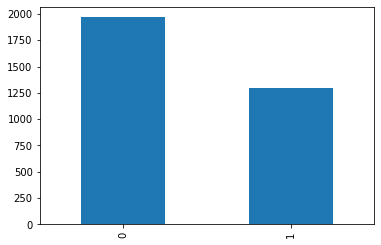

In [31]:
sub.target.value_counts().plot.bar();